# 승인매출정보 EDA

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 설치된 폰트 목록을 갱신하고, 'NanumGothic' 폰트를 기본 폰트로 설정합니다.
font_path = 'C:/Windows/Fonts/NanumGothic.ttf' 
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

import sys
sys.path.append('../utils')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn import set_config
from preprocessing import (
    DateElapsedTransformer, NumericFeaturePreprocessor, ObjectFeaturePreprocessor, NumericTypeOptimizer,
)

pre_optimizer = NumericTypeOptimizer(mode='pre')
date_transformer = DateElapsedTransformer()
numeric_transformer = NumericFeaturePreprocessor()
object_transformer = ObjectFeaturePreprocessor()
post_optimizer = NumericTypeOptimizer(mode='post')

preprocessing_pipeline = Pipeline([
    ('pre_optimizer', pre_optimizer),
    ('object', object_transformer),
    ('date', date_transformer),
    ('numeric', numeric_transformer),
    ('post_optimizer', post_optimizer),
])

# Set display configuration to visualize the pipeline
set_config(display='diagram')

# Display the pipeline
preprocessing_pipeline

Pipeline(steps=[('pre_optimizer', NumericTypeOptimizer(mode='pre')),
                ('object',
                 ObjectFeaturePreprocessor(exclude_columns=['ID', 'Segment'])),
                ('date',
                 DateElapsedTransformer(base_date=Timestamp('2019-01-01 00:00:00'),
                                        exclude_columns=['ID', 'Segment',
                                                         '기준년월'])),
                ('numeric',
                 NumericFeaturePreprocessor(exclude_columns=['기준년월'])),
                ('post_optimizer', NumericTypeOptimizer())])

In [3]:
from sklearn.preprocessing import LabelEncoder
from data_loader import load_data

tx_df, tx_test_df = load_data("3.승인매출정보")

X = tx_df.drop(columns=['ID', '기준년월'])
X = preprocessing_pipeline.fit_transform(X)
X.info()

✅ File: ../../dataset/train/3.승인매출정보\201807_train_승인매출정보.parquet Completed!
✅ File: ../../dataset/train/3.승인매출정보\201808_train_승인매출정보.parquet Completed!
✅ File: ../../dataset/train/3.승인매출정보\201809_train_승인매출정보.parquet Completed!
✅ File: ../../dataset/train/3.승인매출정보\201810_train_승인매출정보.parquet Completed!
✅ File: ../../dataset/train/3.승인매출정보\201811_train_승인매출정보.parquet Completed!
✅ File: ../../dataset/train/3.승인매출정보\201812_train_승인매출정보.parquet Completed!
🔹 Shape : (2400000, 406)

✅ File: ../../dataset/test/3.승인매출정보\201807_test_승인매출정보.parquet Completed!
✅ File: ../../dataset/test/3.승인매출정보\201808_test_승인매출정보.parquet Completed!
✅ File: ../../dataset/test/3.승인매출정보\201809_test_승인매출정보.parquet Completed!
✅ File: ../../dataset/test/3.승인매출정보\201810_test_승인매출정보.parquet Completed!
✅ File: ../../dataset/test/3.승인매출정보\201811_test_승인매출정보.parquet Completed!
✅ File: ../../dataset/test/3.승인매출정보\201812_test_승인매출정보.parquet Completed!
🔹 Shape : (600000, 406)
Numeric Type Optimizer Transforming...
🧠 [mode=pre

In [4]:
import numpy as np

def optimize_numeric_types(df, verbose=True):
    """
    DataFrame의 수치형(int, float) 컬럼을 숫자 범위에 맞춰 다운캐스팅하여 메모리를 최적화
    
    Parameters:
    - df (pd.DataFrame): 입력 데이터프레임
    - verbose (bool): 최적화 전후 메모리 사용량 출력 여부

    Returns:
    - pd.DataFrame: 최적화된 데이터프레임
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2 # MB단위로 변환
    
    for col in df.select_dtypes(include=['int', 'float']).columns:
        col_type = df[col].dtypes
        
        if np.issubdtype(col_type, np.integer):
            c_min = df[col].min()
            c_max = df[col].max()
            
            if c_min >= 0:
                if c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                else:
                    df[col] = df[col].astype(np.uint64)
            else:
                if np.iinfo(np.int8).min <= c_min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif np.iinfo(np.int16).min <= c_min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif np.iinfo(np.int32).min <= c_min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
                    
        elif np.issubdtype(col_type, np.floating):
            c_min = df[col].min()
            c_max = df[col].max()
            
            if np.finfo(np.float16).min <= c_min and c_max <= np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif np.finfo(np.float32).min <= c_min and c_max <= np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    
    if verbose:
        print(f"🔹 메모리 사용량: {start_mem:.2f} MB → {end_mem:.2f} MB  ({100*(start_mem-end_mem)/start_mem:.1f}% 감소)")
    
    return df

In [5]:
tx_df = optimize_numeric_types(tx_df)
tx_test_df = optimize_numeric_types(tx_test_df)

🔹 메모리 사용량: 9165.26 MB → 3628.61 MB  (60.4% 감소)
🔹 메모리 사용량: 2288.73 MB → 900.56 MB  (60.7% 감소)


In [ ]:
tx_df.to_parquet('../dataset/train/3.승인매출정보_최적화.parquet', index=False, engine='fastparquet')
tx_test_df.to_parquet('../dataset/test/3.승인매출정보_최적화.parquet', index=False, engine='fastparquet')

# tx_df = pd.read_parquet('../dataset/train/3.승인매출정보_최적화.parquet', engine='fastparquet')
# tx_test_df = pd.read_parquet('../dataset/test/3.승인매출정보_최적화.parquet', engine='fastparquet')

In [51]:
object_columns = tx_df.select_dtypes(include=['object']).columns
object_columns

Index(['ID', '_1순위업종', '_2순위업종', '_3순위업종', '_1순위쇼핑업종', '_2순위쇼핑업종', '_3순위쇼핑업종',
       '_1순위교통업종', '_2순위교통업종', '_3순위교통업종', '_1순위여유업종', '_2순위여유업종', '_3순위여유업종',
       '_1순위납부업종', '_2순위납부업종', '_3순위납부업종', '최종카드론_신청경로코드', '이용금액대'],
      dtype='object')

In [52]:
unique_values = {col: tx_df[col].unique() for col in object_columns if col != 'ID'}
unique_values

{'_1순위업종': array(['납부', '쇼핑', None, '사교활동', '교육', '교통', '해외', '의료', '여유생활', '일상생활',
        '요식'], dtype=object),
 '_2순위업종': array(['쇼핑', '납부', '사교활동', None, '교통', '해외', '의료', '교육', '여유생활', '일상생활',
        '요식'], dtype=object),
 '_3순위업종': array(['사교활동', '교통', None, '납부', '쇼핑', '여유생활', '의료', '해외', '일상생활', '교육',
        '요식'], dtype=object),
 '_1순위쇼핑업종': array(['쇼핑기타', '도소매', '온라인', '마트', None, '슈퍼마켓', '편의점', '백화점', '아울렛'],
       dtype=object),
 '_2순위쇼핑업종': array([None, '슈퍼마켓', '도소매', '편의점', '마트', '쇼핑기타', '온라인', '아울렛', '백화점'],
       dtype=object),
 '_3순위쇼핑업종': array([None, '편의점', '마트', '슈퍼마켓', '도소매', '쇼핑기타', '백화점', '아울렛', '온라인'],
       dtype=object),
 '_1순위교통업종': array(['택시', '주유', None, '버스지하철', '정비', '철도버스'], dtype=object),
 '_2순위교통업종': array(['버스지하철', '철도버스', None, '정비', '택시', '주유', '통행료'], dtype=object),
 '_3순위교통업종': array([None, '택시', '철도버스', '정비', '버스지하철', '통행료'], dtype=object),
 '_1순위여유업종': array([None, '공연', '여유기타', '운동', 'Pet', '항공', '숙박', '공원'], dtype=object),
 '_2순위여유업종': a

In [53]:
for col in unique_values:
    tx_df[col] = tx_df[col].fillna('Unknown')
    tx_df[col] = tx_df[col].astype('category')

In [54]:
for col in unique_values:
    tx_test_df[col] = tx_test_df[col].fillna('Unknown')
    tx_test_df[col] = tx_test_df[col].astype('category')

In [55]:
unique_values = {col: tx_df[col].unique() for col in object_columns if col != 'ID'}
unique_values

{'_1순위업종': ['납부', '쇼핑', 'Unknown', '사교활동', '교육', ..., '해외', '의료', '여유생활', '일상생활', '요식']
 Length: 11
 Categories (11, object): ['Unknown', '교육', '교통', '납부', ..., '요식', '의료', '일상생활', '해외'],
 '_2순위업종': ['쇼핑', '납부', '사교활동', 'Unknown', '교통', ..., '의료', '교육', '여유생활', '일상생활', '요식']
 Length: 11
 Categories (11, object): ['Unknown', '교육', '교통', '납부', ..., '요식', '의료', '일상생활', '해외'],
 '_3순위업종': ['사교활동', '교통', 'Unknown', '납부', '쇼핑', ..., '의료', '해외', '일상생활', '교육', '요식']
 Length: 11
 Categories (11, object): ['Unknown', '교육', '교통', '납부', ..., '요식', '의료', '일상생활', '해외'],
 '_1순위쇼핑업종': ['쇼핑기타', '도소매', '온라인', '마트', 'Unknown', '슈퍼마켓', '편의점', '백화점', '아울렛']
 Categories (9, object): ['Unknown', '도소매', '마트', '백화점', ..., '슈퍼마켓', '아울렛', '온라인', '편의점'],
 '_2순위쇼핑업종': ['Unknown', '슈퍼마켓', '도소매', '편의점', '마트', '쇼핑기타', '온라인', '아울렛', '백화점']
 Categories (9, object): ['Unknown', '도소매', '마트', '백화점', ..., '슈퍼마켓', '아울렛', '온라인', '편의점'],
 '_3순위쇼핑업종': ['Unknown', '편의점', '마트', '슈퍼마켓', '도소매', '쇼핑기타', '백화점', '아울렛', '온라인']
 Categor

In [56]:
int_columns = tx_df.select_dtypes(include=['integer']).columns
int_columns

Index(['기준년월', '최종이용일자_기본', '최종이용일자_신판', '최종이용일자_CA', '최종이용일자_카드론',
       '최종이용일자_체크', '최종이용일자_일시불', '최종이용일자_할부', '이용건수_신용_B0M', '이용건수_신판_B0M',
       ...
       '승인거절건수_B0M', '승인거절건수_한도초과_B0M', '승인거절건수_BL_B0M', '승인거절건수_입력오류_B0M',
       '승인거절건수_기타_B0M', '승인거절건수_R3M', '승인거절건수_한도초과_R3M', '승인거절건수_BL_R3M',
       '승인거절건수_입력오류_R3M', '승인거절건수_기타_R3M'],
      dtype='object', length=385)

In [57]:
int_unique_values = {col: tx_df[col].unique() for col in int_columns if col != 'ID'}
int_unique_values

{'기준년월': array([201807, 201808, 201809, 201810, 201811, 201812], dtype=uint32),
 '최종이용일자_기본': array([20180719, 20180706, 20180721, ..., 20181225, 20181201, 20181206],
       shape=(1275,), dtype=uint32),
 '최종이용일자_신판': array([20180713, 20180719, 20180706, ..., 20181202, 20181201, 20181206],
       shape=(1262,), dtype=uint32),
 '최종이용일자_CA': array([20180719, 20170728, 20180706, ..., 20181204, 20181202, 20181231],
       shape=(3097,), dtype=uint32),
 '최종이용일자_카드론': array([   10101, 20170327, 20151119, ..., 20181014, 20181126, 20181215],
       shape=(1667,), dtype=uint32),
 '최종이용일자_체크': array([20180203,    10101, 20141230, ..., 20181203, 20181207, 20181218],
       shape=(2244,), dtype=uint32),
 '최종이용일자_일시불': array([20180709, 20180719, 20180706, ..., 20181219, 20181218, 20181223],
       shape=(1088,), dtype=uint32),
 '최종이용일자_할부': array([20180713, 20171231, 20180627, ..., 20181230, 20181226, 20181231],
       shape=(2246,), dtype=uint32),
 '이용건수_신용_B0M': array([11, 13, 12,  6, -2,  0,  9,

In [58]:
# 유니크 값이 0개이거나 1개인 컬럼 찾기
drop_cols = [col for col in df.columns if df[col].nunique(dropna=False) <= 1 and col != '기준년월']
print(f"🔹 개수: {len(drop_cols)}")
drop_cols

🔹 개수: 45


['이용건수_부분무이자_B0M',
 '이용금액_부분무이자_B0M',
 '이용건수_부분무이자_R6M',
 '이용금액_부분무이자_R6M',
 '이용건수_부분무이자_R3M',
 '이용금액_부분무이자_R3M',
 '이용개월수_부분무이자_R3M',
 '여유_여행이용금액',
 '납부_렌탈료이용금액',
 '납부_유선방송이용금액',
 '납부_건강연금이용금액',
 '할부건수_무이자_14M_R12M',
 '할부건수_부분_3M_R12M',
 '할부건수_부분_6M_R12M',
 '할부건수_부분_14M_R12M',
 '할부금액_부분_3M_R12M',
 '할부금액_부분_6M_R12M',
 'RP건수_유선방송_B0M',
 'RP건수_건강_B0M',
 'RP후경과월_유선방송',
 'RP후경과월_건강',
 '증감_RP건수_유선방송_전월',
 '증감_RP건수_건강_전월',
 '이용개월수_당사페이_R6M',
 '이용개월수_당사기타_R6M',
 '이용금액_당사페이_R6M',
 '이용금액_당사기타_R6M',
 '이용건수_당사페이_R6M',
 '이용건수_당사기타_R6M',
 '이용금액_당사페이_R3M',
 '이용금액_당사기타_R3M',
 '이용건수_당사페이_R3M',
 '이용건수_당사기타_R3M',
 '이용금액_당사페이_B0M',
 '이용금액_당사기타_B0M',
 '이용건수_당사페이_B0M',
 '이용건수_당사기타_B0M',
 '신청건수_ATM_CL_B0',
 '신청건수_ATM_CL_R6M',
 '승인거절건수_BL_B0M',
 '승인거절건수_입력오류_B0M',
 '승인거절건수_기타_B0M',
 '승인거절건수_BL_R3M',
 '승인거절건수_입력오류_R3M',
 '승인거절건수_기타_R3M']

In [59]:
tx_df = tx_df.drop(columns=drop_cols)
tx_test_df = tx_test_df.drop(columns=drop_cols)

In [60]:
tx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Columns: 361 entries, 기준년월 to 이용금액대
dtypes: category(17), float32(3), int16(16), int32(10), int8(21), object(1), uint16(96), uint32(49), uint8(148)
memory usage: 1.5+ GB


In [62]:
float_columns = tx_df.select_dtypes(include=['float16', 'float32']).columns
float_columns

Index(['최종카드론_금융상환방식코드', '최종카드론_대출이율', '최종카드론_대출일자'], dtype='object')

In [63]:
float_unique_values = {col: tx_df[col].unique() for col in float_columns if col != 'ID'}
float_unique_values

{'최종카드론_금융상환방식코드': array([nan,  5.,  3.,  2.], dtype=float32),
 '최종카드론_대출이율': array([ 0.       , 13.21875  , 14.2109375, ...,  9.40625  , 19.765625 ,
         9.453125 ], shape=(1085,), dtype=float32),
 '최종카드론_대출일자': array([      nan, 20170328., 20151120., 20180604., 20180206., 20160630.,
        20150114., 20150514., 20141018., 20150702., 20161208., 20141212.,
        20160222., 20170728., 20150716., 20170720., 20151002., 20150524.,
        20160928., 20180526., 20150620., 20160812., 20150912., 20170104.,
        20141204., 20171112., 20171108., 20170320., 20160616., 20170100.,
        20141118., 20180324., 20171116., 20160724., 20161032., 20180510.,
        20180404., 20150124., 20160330., 20171224., 20150328., 20160400.,
        20150722., 20140728., 20171208., 20170700., 20160506., 20180612.,
        20150312., 20141020., 20160208., 20150610., 20180424., 20150530.,
        20180124., 20171220., 20150824., 20150228., 20150928., 20140828.,
        20150104., 20151032., 20141108., 201

In [64]:
# 먼저 float32로 변환하고, 그 다음 category로 변환
tx_df['최종카드론_금융상환방식코드'] = tx_df['최종카드론_금융상환방식코드'].fillna(0).astype('float32').astype('category')
tx_test_df['최종카드론_금융상환방식코드'] = tx_test_df['최종카드론_금융상환방식코드'].fillna(0).astype('float32').astype('category')

In [ ]:
# datetime 변환
tx_df['최종카드론_대출일자'] = pd.to_datetime(tx_df['최종카드론_대출일자'], format='%Y%m%d', errors='coerce')

# 기준일
today = pd.to_datetime('2019-01-01')

new_cols = pd.DataFrame({
    '대출연도': tx_df['최종카드론_대출일자'].dt.year,
    '대출월': tx_df['최종카드론_대출일자'].dt.month,
    '대출일': tx_df['최종카드론_대출일자'].dt.day,
    '대출_경과일수': (today - tx_df['최종카드론_대출일자']).dt.days,
})

tx_df = pd.concat([tx_df, new_cols], axis=1)
tx_df = tx_df.drop(columns=['최종카드론_대출일자'])


In [ ]:
tx_test_df['최종카드론_대출일자'] = pd.to_datetime(tx_test_df['최종카드론_대출일자'], format='%Y%m%d', errors='coerce')

new_cols = pd.DataFrame({
    '대출연도': tx_test_df['최종카드론_대출일자'].dt.year,
    '대출월': tx_test_df['최종카드론_대출일자'].dt.month,
    '대출일': tx_test_df['최종카드론_대출일자'].dt.day,
    '대출_경과일수': (today - tx_test_df['최종카드론_대출일자']).dt.days,
})

tx_test_df = pd.concat([tx_test_df, new_cols], axis=1)

tx_test_df = tx_test_df.drop(columns=['최종카드론_대출일자'])

In [68]:
new_columns = ['대출연도', '대출월', '대출일', '대출_경과일수']
for col in new_columns:
    tx_df[col] = tx_df[col].fillna(0).astype('int32')
    tx_test_df[col] = tx_test_df[col].fillna(0).astype('int32')

In [72]:
tx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Columns: 365 entries, 기준년월 to 대출_경과일수
dtypes: category(18), datetime64[ns](1), float32(1), int16(16), int32(14), int8(21), object(1), uint16(96), uint32(49), uint8(148)
memory usage: 1.5+ GB


In [70]:
tx_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 364 entries, 기준년월 to 대출_경과일수
dtypes: category(18), float32(1), int16(16), int32(14), int8(21), object(1), uint16(99), uint32(46), uint8(148)
memory usage: 382.8+ MB


In [73]:
segment_df = pd.read_parquet('../dataset/train/member.parquet', engine='fastparquet')
segment_df = segment_df[['ID', '기준년월', 'Segment']]

tx_df = tx_df.merge(segment_df, on=['ID', '기준년월'], how='left')

# Feature Selection

In [74]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

def get_feature_importance(X, y, importance_type='gain', plot_top_n=30):
    """
    LightGBM을 이용해 Feature Importance를 계산하고, 상위 feature를 시각화합니다.
    
    Parameters:
    - X (pd.DataFrame): feature 데이터
    - y (pd.Series or np.array): target 데이터
    - importance_type (str): 'gain' 또는 'split' (중요도 기준)
    - plot_top_n (int): 중요도가 높은 feature 몇 개를 plot할지
    - random_state (int): seed 고정

    Returns:
    - feature_importance_df (pd.DataFrame): feature importance 데이터프레임
    - model (lgb.Booster): 학습된 LightGBM 모델
    """

    # LightGBM 데이터셋 구성
    lgb_train = lgb.Dataset(X, label=y)

    # LightGBM 기본 파라미터 (가볍게 학습)
    params = {
        'objective': 'multiclass',   # 다중 클래스 분류
        'num_class': 5,  # 클래스 수 자동 지정
        'boosting_type': 'gbdt',
        'metric': 'multi_logloss',   # 다중 클래스 로지 손실
        'verbosity': -1,
        'seed': 42,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 20
    }

    # 빠르게 학습 (에포크 100회로 제한)
    model = lgb.train(params, lgb_train, num_boost_round=100)

    # Feature Importance 가져오기
    importance = model.feature_importance(importance_type=importance_type)
    feature_names = X.columns

    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    # 시각화
    top_features = feature_importance_df.head(plot_top_n)
    
    plt.figure(figsize=(10, max(6, plot_top_n // 2)))
    plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
    plt.xlabel('Importance')
    plt.title(f'Top {plot_top_n} Feature Importance ({importance_type})')
    plt.tight_layout()
    plt.show()

    return feature_importance_df, model


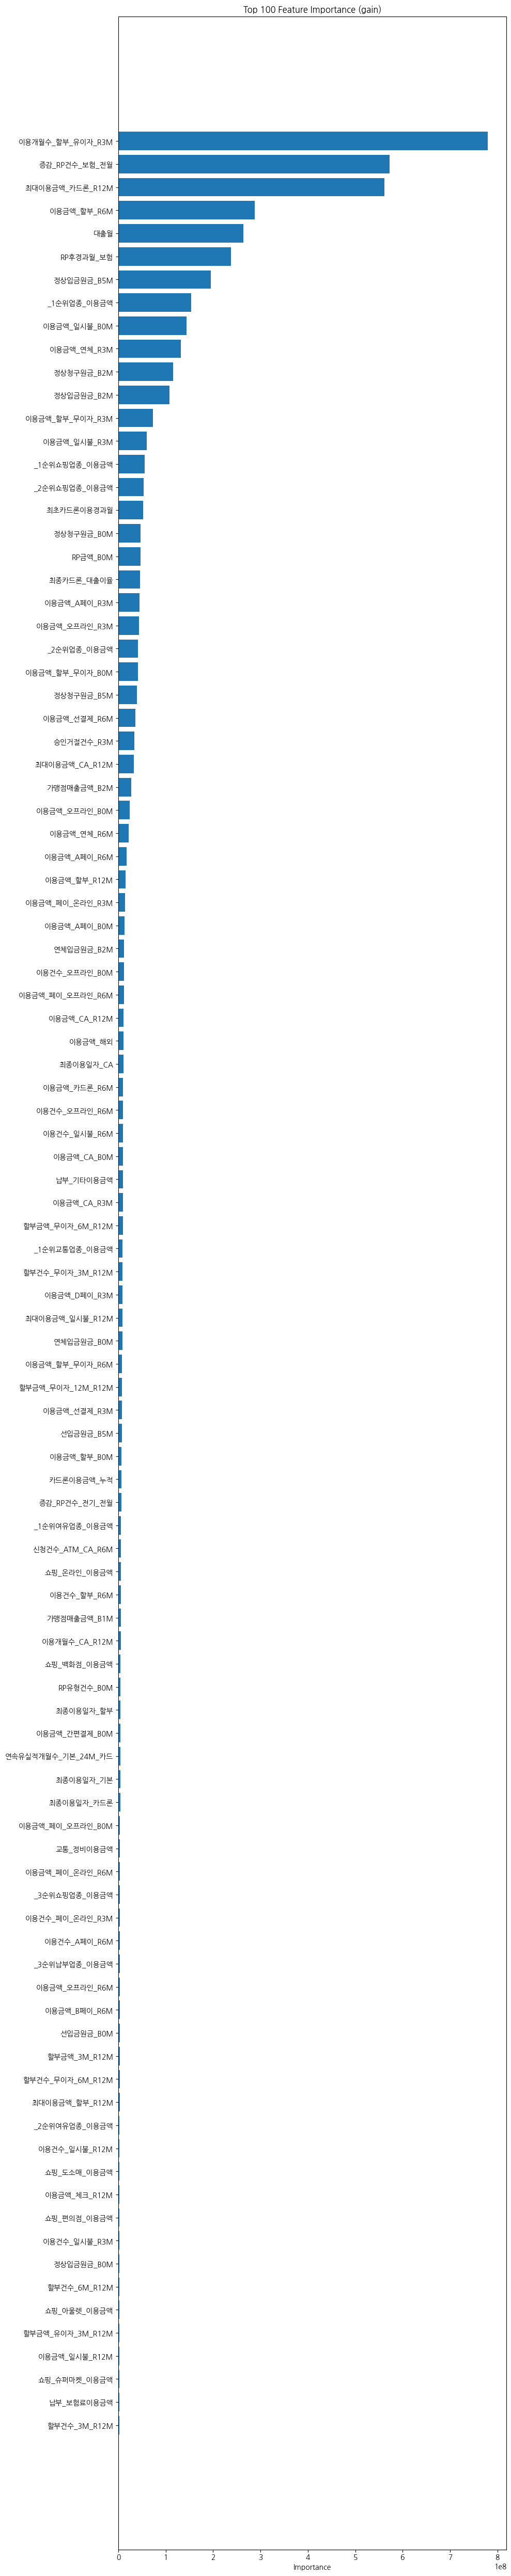

In [78]:
X = tx_df.drop(columns=['ID', '기준년월', 'Segment'])

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(tx_df['Segment'])

importance_df, model = get_feature_importance(X, y, importance_type='gain', plot_top_n=100)

순위 | Feature | 의미 | 해석
---|---|---|---
1 | 이용개월수_할부_유이자_R3M | 최근 3개월간 유이자 할부를 이용한 개월 수 | 📌 신용활동 패턴이 Segmentation(세그먼트)과 직접 연결되어 있음
2 | 증감_RP건수_보험_전월 | 보험 관련 RP업종(Recurring Payment, 정기 결제)의 전월 대비 증감 건수 | 📌 보험 관련 활동의 증감도 고객 등급에 영향을 미침
3 | 최대이용금액_카드론_R12M | 최근 1년간 카드론 이용 중 가장 큰 금액 | 📌 금융상품(대출) 활용 규모가 중요 신호로 작용함
4 | 이용금액_할부_R6M | 최근 6개월간 할부 이용금액 총합 | 📌 신용/소비 규모가 segment 구분에 민감하게 반영됨
5 | 대출월 | 대출 실행 시점의 월 정보 | 📌 대출시기가 세그먼트 구분의 힌트가 됨 (계절성 소비, 금융 이벤트와 관련 가능성)

- 카드 이용 패턴, 할부/대출 이용 패턴, RP업종 활동 같은 금융 소비 행태가 세그먼트(고객 그룹) 분류에 매우 중요한 역할 수행
- 앞으로 다른 카테고리 (ex. 청구입금정보, 잔액정보) 전처리할 때도 "대출, 할부, RP활동" 관련 feature를 특히 집중해서 다뤄야 한다.
- 단순 거래 수(count)보다 금액, 변화율(증감), 최대/최소 기록 같은 게 모델이 훨씬 중요하게 보고 있다는 점

In [79]:
def select_top_features(importance_df, X, top_percent=0.3):
    """
    중요도 데이터프레임에서 상위 top_percent 비율만큼 feature를 선택하여 데이터셋 추출

    Parameters:
    - importance_df (pd.DataFrame): feature와 importance를 가진 데이터프레임
    - X (pd.DataFrame): 원본 feature 데이터셋
    - top_percent (float): 상위 몇 %를 선택할지 (기본 30%)

    Returns:
    - X_top (pd.DataFrame): 상위 feature만 선택된 데이터프레임
    - selected_features (list): 선택된 feature 리스트
    """
    n_features = int(len(importance_df) * top_percent)
    selected_features = importance_df['feature'].iloc[:n_features].tolist()
    X_top = X[selected_features]
    return X_top, selected_features

In [81]:
X_top, selected_features = select_top_features(importance_df, X, top_percent=0.3)
print(f"🔹 선택된 feature 수: {len(selected_features)}")
print(f"🔹 선택된 feature: {selected_features}")

🔹 선택된 feature 수: 108
🔹 선택된 feature: ['이용개월수_할부_유이자_R3M', '증감_RP건수_보험_전월', '최대이용금액_카드론_R12M', '이용금액_할부_R6M', '대출월', 'RP후경과월_보험', '정상입금원금_B5M', '_1순위업종_이용금액', '이용금액_일시불_B0M', '이용금액_연체_R3M', '정상청구원금_B2M', '정상입금원금_B2M', '이용금액_할부_무이자_R3M', '이용금액_일시불_R3M', '_1순위쇼핑업종_이용금액', '_2순위쇼핑업종_이용금액', '최초카드론이용경과월', '정상청구원금_B0M', 'RP금액_B0M', '최종카드론_대출이율', '이용금액_A페이_R3M', '이용금액_오프라인_R3M', '_2순위업종_이용금액', '이용금액_할부_무이자_B0M', '정상청구원금_B5M', '이용금액_선결제_R6M', '승인거절건수_R3M', '최대이용금액_CA_R12M', '가맹점매출금액_B2M', '이용금액_오프라인_B0M', '이용금액_연체_R6M', '이용금액_A페이_R6M', '이용금액_할부_R12M', '이용금액_페이_온라인_R3M', '이용금액_A페이_B0M', '연체입금원금_B2M', '이용건수_오프라인_B0M', '이용금액_페이_오프라인_R6M', '이용금액_CA_R12M', '이용금액_해외', '최종이용일자_CA', '이용금액_카드론_R6M', '이용건수_오프라인_R6M', '이용건수_일시불_R6M', '이용금액_CA_B0M', '납부_기타이용금액', '이용금액_CA_R3M', '할부금액_무이자_6M_R12M', '_1순위교통업종_이용금액', '할부건수_무이자_3M_R12M', '이용금액_D페이_R3M', '최대이용금액_일시불_R12M', '연체입금원금_B0M', '이용금액_할부_무이자_R6M', '할부금액_무이자_12M_R12M', '이용금액_선결제_R3M', '선입금원금_B5M', '이용금액_할부_B0M', '카드론이용금액_누적', '증감_RP건수_전기_전월', '_1순위여유업종_이용금액

In [112]:
def plot_feature_correlation(X_top, threshold=0.8):
    """
    상위 feature들 간의 상관계수 행렬을 시각화하고, 
    threshold 이상인 feature쌍을 출력

    Parameters:
    - X_top (pd.DataFrame): 상위 feature 데이터프레임
    - threshold (float): 높은 상관관계로 간주할 기준
    """
    # 수치치형 feature만 선택
    numeric_features = X_top.select_dtypes(include=['number'])
    corr_matrix = numeric_features.corr()
    print(" 상관계수 행렬 생성 완료..!")

    # 상관관계 히트맵 그리기
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Top Features')
    plt.show()

    # threshold 이상인 feature 쌍 출력
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    if high_corr_pairs:
        print(f"\n상관계수 {threshold} 이상인 feature 쌍:")
        for f1, f2, corr in sorted(high_corr_pairs, key=lambda x: -abs(x[2])):
            print(f"🔹{f1} vs {f2}: 상관계수 = {corr:.3f}")
    else:
        print(f"\n상관계수 {threshold} 이상인 feature 쌍이 없습니다.")
    
    return high_corr_pairs

 상관계수 행렬 생성 완료..!


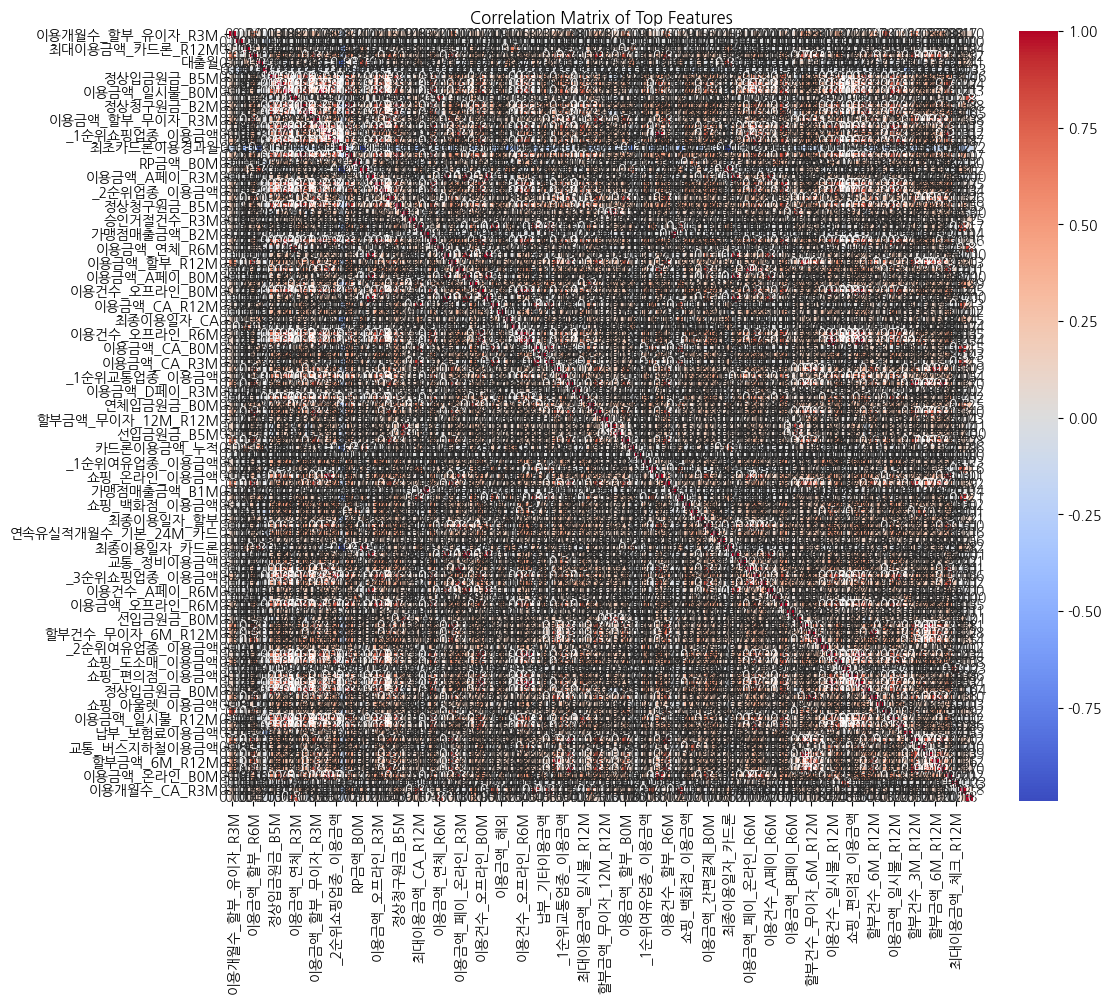


상관계수 0.8 이상인 feature 쌍:
🔹쇼핑_온라인_이용금액 vs _1순위쇼핑업종_이용금액: 상관계수 = 0.992
🔹최종카드론_대출이율 vs 최초카드론이용경과월: 상관계수 = -0.991
🔹이용건수_일시불_R3M vs 이용건수_일시불_R6M: 상관계수 = 0.990
🔹이용금액_일시불_R3M vs 이용금액_일시불_B0M: 상관계수 = 0.987
🔹가맹점매출금액_B1M vs 가맹점매출금액_B2M: 상관계수 = 0.987
🔹이용금액_페이_오프라인_R6M vs 이용금액_A페이_R6M: 상관계수 = 0.985
🔹이용건수_일시불_R12M vs 이용건수_일시불_R6M: 상관계수 = 0.979
🔹이용금액_페이_오프라인_B0M vs 이용금액_A페이_B0M: 상관계수 = 0.971
🔹이용건수_일시불_R3M vs 이용건수_일시불_R12M: 상관계수 = 0.968
🔹이용금액_A페이_R6M vs 이용금액_A페이_R3M: 상관계수 = 0.967
🔹이용금액_A페이_B0M vs 이용금액_A페이_R3M: 상관계수 = 0.966
🔹이용건수_할부_무이자_R12M vs 할부건수_무이자_3M_R12M: 상관계수 = 0.966
🔹최종이용일자_카드론 vs 최초카드론이용경과월: 상관계수 = -0.963
🔹이용금액_CA_R3M vs 이용금액_CA_B0M: 상관계수 = 0.962
🔹이용금액_페이_온라인_R6M vs 이용금액_페이_온라인_R3M: 상관계수 = 0.960
🔹이용금액_페이_오프라인_R6M vs 이용금액_A페이_R3M: 상관계수 = 0.958
🔹할부건수_3M_R12M vs 할부건수_무이자_3M_R12M: 상관계수 = 0.956
🔹할부건수_6M_R12M vs 할부건수_무이자_6M_R12M: 상관계수 = 0.954
🔹정상청구원금_B0M vs 정상청구원금_B2M: 상관계수 = 0.954
🔹이용금액_선결제_R3M vs 이용금액_선결제_R6M: 상관계수 = 0.953
🔹이용금액_페이_오프라인_B0M vs 이용금액_A페이_R3M: 상관계수 = 0.950
🔹할부금액_무이자_3M_R12M vs 할부금액

In [113]:
# 상관계수 0.8 이상인 feature 쌍을 시각화
high_corr_pairs = plot_feature_correlation(X_top, threshold=0.8)

In [114]:
high_corr_pairs

[('정상청구원금_B2M', '이용금액_일시불_B0M', np.float64(0.8064713349979258)),
 ('정상입금원금_B2M', '정상입금원금_B5M', np.float64(0.8630076094407318)),
 ('정상입금원금_B2M', '정상청구원금_B2M', np.float64(0.852243375094208)),
 ('이용금액_할부_무이자_R3M', '이용금액_할부_R6M', np.float64(0.8008111425049873)),
 ('이용금액_일시불_R3M', '이용금액_일시불_B0M', np.float64(0.9874421320151608)),
 ('이용금액_일시불_R3M', '정상청구원금_B2M', np.float64(0.8108104455215084)),
 ('_2순위쇼핑업종_이용금액', '이용금액_일시불_B0M', np.float64(0.8263042900824072)),
 ('_2순위쇼핑업종_이용금액', '이용금액_일시불_R3M', np.float64(0.8247933969424632)),
 ('최초카드론이용경과월', '대출월', np.float64(-0.8004197749818991)),
 ('정상청구원금_B0M', '이용금액_일시불_B0M', np.float64(0.8219721754238837)),
 ('정상청구원금_B0M', '정상청구원금_B2M', np.float64(0.9535677098155435)),
 ('정상청구원금_B0M', '정상입금원금_B2M', np.float64(0.8002957698160093)),
 ('정상청구원금_B0M', '이용금액_일시불_R3M', np.float64(0.8255192947741358)),
 ('최종카드론_대출이율', '최초카드론이용경과월', np.float64(-0.991266635879074)),
 ('이용금액_오프라인_R3M', '이용금액_일시불_B0M', np.float64(0.8841858460555895)),
 ('이용금액_오프라인_R3M', '이용금액_일시불_

In [ ]:
importance_list = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()
importance_dict = dict(zip(feature_names, importance_list))

# importance_dict 정렬
sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

In [102]:
sorted_importance

{'이용개월수_할부_유이자_R3M': np.float64(779707008.0),
 '증감_RP건수_보험_전월': np.float64(571923515.9120178),
 '최대이용금액_카드론_R12M': np.float64(560966851.9310493),
 '이용금액_할부_R6M': np.float64(287749870.5742321),
 '대출월': np.float64(264232976.91138458),
 'RP후경과월_보험': np.float64(237577798.72506714),
 '정상입금원금_B5M': np.float64(194615395.41518402),
 '_1순위업종_이용금액': np.float64(154093362.13475227),
 '이용금액_일시불_B0M': np.float64(143918452.70097542),
 '이용금액_연체_R3M': np.float64(131880638.12470245),
 '정상청구원금_B2M': np.float64(115281928.00514221),
 '정상입금원금_B2M': np.float64(108255751.25116539),
 '이용금액_할부_무이자_R3M': np.float64(73248853.08081055),
 '이용금액_일시불_R3M': np.float64(60370273.21474075),
 '_1순위쇼핑업종_이용금액': np.float64(55778928.43270683),
 '_2순위쇼핑업종_이용금액': np.float64(53626347.97408295),
 '최초카드론이용경과월': np.float64(52052462.3334713),
 '정상청구원금_B0M': np.float64(47067486.28890991),
 'RP금액_B0M': np.float64(46849162.68680954),
 '최종카드론_대출이율': np.float64(45829187.082546234),
 '이용금액_A페이_R3M': np.float64(44567013.88520813),
 '이용금액_오

In [120]:
correlated_pairs = [(f1, f2) for f1, f2, corr in high_corr_pairs if abs(corr) > 0.9]

feature_to_drops = set()

for f1, f2 in correlated_pairs:
    imp1 = sorted_importance.get(f1, 0)
    imp2 = sorted_importance.get(f2, 0)

    if imp1 > imp2:
        feature_to_drops.add(f2)
    else:
        feature_to_drops.add(f1)

feature_to_drops

{'_3순위쇼핑업종_이용금액',
 '가맹점매출금액_B1M',
 '쇼핑_온라인_이용금액',
 '이용개월수_CA_R3M',
 '이용건수_A페이_R6M',
 '이용건수_오프라인_R6M',
 '이용건수_일시불_R12M',
 '이용건수_일시불_R3M',
 '이용건수_일시불_R6M',
 '이용건수_할부_무이자_R12M',
 '이용금액_A페이_B0M',
 '이용금액_A페이_R6M',
 '이용금액_CA_R12M',
 '이용금액_CA_R3M',
 '이용금액_선결제_R3M',
 '이용금액_연체_R6M',
 '이용금액_오프라인_B0M',
 '이용금액_오프라인_R6M',
 '이용금액_온라인_B0M',
 '이용금액_일시불_R12M',
 '이용금액_일시불_R3M',
 '이용금액_페이_오프라인_B0M',
 '이용금액_페이_오프라인_R6M',
 '이용금액_페이_온라인_R6M',
 '이용금액_할부_무이자_R6M',
 '정상입금원금_B0M',
 '정상청구원금_B0M',
 '정상청구원금_B5M',
 '최종이용일자_카드론',
 '최종카드론_대출이율',
 '할부건수_3M_R12M',
 '할부건수_6M_R12M',
 '할부금액_3M_R12M',
 '할부금액_6M_R12M',
 '할부금액_무이자_3M_R12M'}

In [122]:
temp_df = X_top.copy()

for col in feature_to_drops:
    X_top = X_top.drop(columns=[col])

X_top.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 73 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   이용개월수_할부_유이자_R3M    uint8 
 1   증감_RP건수_보험_전월       int8  
 2   최대이용금액_카드론_R12M     uint32
 3   이용금액_할부_R6M         int32 
 4   대출월                 int32 
 5   RP후경과월_보험           uint8 
 6   정상입금원금_B5M          uint32
 7   _1순위업종_이용금액         uint32
 8   이용금액_일시불_B0M        int16 
 9   이용금액_연체_R3M         uint16
 10  정상청구원금_B2M          uint32
 11  정상입금원금_B2M          uint32
 12  이용금액_할부_무이자_R3M     int16 
 13  _1순위쇼핑업종_이용금액       uint32
 14  _2순위쇼핑업종_이용금액       uint16
 15  최초카드론이용경과월          uint16
 16  RP금액_B0M            uint16
 17  이용금액_A페이_R3M        uint16
 18  이용금액_오프라인_R3M       uint32
 19  _2순위업종_이용금액         uint16
 20  이용금액_할부_무이자_B0M     uint16
 21  이용금액_선결제_R6M        uint32
 22  승인거절건수_R3M          uint8 
 23  최대이용금액_CA_R12M      uint32
 24  가맹점매출금액_B2M         uint16
 25  이용금액_할부_R12M      

In [133]:
X_top.columns

Index(['이용개월수_할부_유이자_R3M', '증감_RP건수_보험_전월', '최대이용금액_카드론_R12M', '이용금액_할부_R6M',
       '대출월', 'RP후경과월_보험', '정상입금원금_B5M', '_1순위업종_이용금액', '이용금액_일시불_B0M',
       '이용금액_연체_R3M', '정상청구원금_B2M', '정상입금원금_B2M', '이용금액_할부_무이자_R3M',
       '_1순위쇼핑업종_이용금액', '_2순위쇼핑업종_이용금액', '최초카드론이용경과월', 'RP금액_B0M',
       '이용금액_A페이_R3M', '이용금액_오프라인_R3M', '_2순위업종_이용금액', '이용금액_할부_무이자_B0M',
       '이용금액_선결제_R6M', '승인거절건수_R3M', '최대이용금액_CA_R12M', '가맹점매출금액_B2M',
       '이용금액_할부_R12M', '이용금액_페이_온라인_R3M', '연체입금원금_B2M', '이용건수_오프라인_B0M',
       '이용금액_해외', '최종이용일자_CA', '이용금액_카드론_R6M', '이용금액_CA_B0M', '납부_기타이용금액',
       '할부금액_무이자_6M_R12M', '_1순위교통업종_이용금액', '할부건수_무이자_3M_R12M', '이용금액_D페이_R3M',
       '최대이용금액_일시불_R12M', '연체입금원금_B0M', '할부금액_무이자_12M_R12M', '선입금원금_B5M',
       '이용금액_할부_B0M', '카드론이용금액_누적', '증감_RP건수_전기_전월', '_1순위여유업종_이용금액',
       '신청건수_ATM_CA_R6M', '이용건수_할부_R6M', '이용개월수_CA_R12M', '쇼핑_백화점_이용금액',
       'RP유형건수_B0M', '최종이용일자_할부', '이용금액_간편결제_B0M', '연속유실적개월수_기본_24M_카드',
       '최종이용일자_기본', '교통_정비이용금액', '이용건수_페이_온라인_R3M', 

In [ ]:
# filtered_tx_df = tx_df[['ID', '기준년월'] + X_top.columns.tolist()]
# filtered_tx_df.to_parquet('../dataset/train/tx.parquet', index=False)

filtered_tx_test_df = tx_test_df[['ID', '기준년월'] + X_top.columns.tolist()]
filtered_tx_test_df.to_parquet('../dataset/test/tx.parquet', index=False)